In [56]:
import numpy as np
#%tensorflow_version 2.x

import matplotlib.pyplot as plt
import time

from IPython import display
from IPython.display import clear_output

import glob
import imageio
import PIL

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [57]:
datasets, datasets_info = tfds.load(name='fashion_mnist',
                                    with_info=True,
                                    as_supervised=False,
                                    data_dir="data\\VAE\\")

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

train_ds = (datasets['train']
                 .map(_preprocess)
                 .batch(64, drop_remainder=True)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(buffer_size=64))
test_ds = (datasets['test']
                .map(_preprocess)
                .batch(64, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))


In [58]:
def tile_plot(train,imgs=55,greyscale=True,scale=False,labelling=True):
    # This function plots the images in a tiled fashion, for better visualization.
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 10
    fig, ax = plt.subplots(1,imgs)
    for i,j in enumerate(tfds.as_numpy(train)):
        print(j)
        img= j[0]
        
        label = {
        0 : 'T-shirt/top',
        1 : 'Trouser',
        2 : 'Pullover',
        3 : 'Dress',
        4 : 'Coat',
        5 : 'Sandal',
        6 : 'Shirt',
        7 : 'Sneaker',
        8 : 'Bag',
        9 : 'Ankle boot'
        }
        # if label is still just an integer
        if isinstance(j[1], np.int64):
            if labelling:
                lbl = label[j[1]]
        else:
            indice = np.where(j[1] == 1)
            indice = indice[0]
            if labelling:
                lbl = label[int(indice)]
        subax = fig.add_subplot(rows+1,columns+1,i+1)   
        subax.axis("off")
        if labelling:
            subax.set_title(lbl)

        if greyscale: #Dealing with grayscale images requires a different approach, since imshow doesn't handle them as adroitly as RGB
            if scale: # This is to visualize our normalized images. Since this doesn't conform to the standard scale, we have to define our own
                plt.imshow(np.squeeze(img),vmin=-2, vmax= 2.5,cmap="gray")
            else:
                plt.imshow(tf.cast(np.squeeze(img),tf.uint8),cmap="gray")
        else:
            plt.imshow(tf.cast(img,tf.uint8)) #cast to uint because otherwise there's an error from matplotlib
        ax[i].axis("off")
        if i == (imgs-1): 
            # this is really awkward, but sadly prefetch_datasets are quite particular about indexing.
            # converting them to numpy first might be smarter in the future
            break
    plt.subplots_adjust(top=3)
    plt.show()

#tile_plot(train_dataset,labelling=False)

In [59]:
def binary_plot(data):
    for i in data:
        i = i[0][0]
        #print(tf.cast(i[0],tf.uint8))
        print(np.squeeze(tfds.as_numpy(tf.cast(i,tf.uint8))).shape)
        plt.imshow(np.squeeze((tfds.as_numpy(tf.cast(i,tf.uint8)))))

        break


# binary_plot(train_ds)

In [60]:
def plot_performance(total_epochs, train_loss, test_loss, timing):
    """Helper function to plot the models performance inline during and after training"""
    #clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")

    plt.show()

In [61]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [62]:
class V_Encoder(Model):
    
    def __init__(self):
        super(V_Encoder, self).__init__()

        self.hidden = [
            tfkl.InputLayer(input_shape=input_shape),
            tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
            tfkl.Conv2D(base_depth, 5, strides=1,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(2 * base_depth, 5, strides=2,
                        padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                        padding='valid', activation=tf.nn.leaky_relu),
            tfkl.Flatten(),
            tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
                        activation=None),
            tfpl.MultivariateNormalTriL(encoded_size,
                                        activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),

        ]

    #@tf.function
    def call(self,x,training):
        for i in self.hidden:
            x = i(x,training=training)
        return x


In [63]:
class V_Decoder(Model):
    
    def __init__(self):
        super(V_Decoder, self).__init__()

        self.hidden = [
            tfkl.InputLayer(input_shape=[encoded_size]),
            tfkl.Reshape([1, 1, encoded_size]),
            tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                                padding='valid', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                                padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                                padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                                padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                                padding='same', activation=tf.nn.leaky_relu),
            tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                        padding='same', activation=None),
            tfkl.Flatten(),
            tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
        ]


    #@tf.function
    def call(self,x,training):
        for i in self.hidden:
            x = i(x,training=training)
        return x

Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [64]:
class VAE(Model):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        self.hidden = [
            V_Encoder(),
            V_Decoder()
        ]

    #@tf.function
    def call(self,x,training):
        for i in self.hidden:
            x = i(x,training=training)
        return x

In [65]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  with tf.GradientTape() as tape:
    prediction = model(data, training = True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss 


def test_step(model, test_data, loss_function):
  # test over complete test data

  test_loss_aggregator = []

  for (data, target) in test_data:
    prediction = model(data, training = False)
    
    #print(target.shape)
    #print(prediction.shape)
    sample_test_loss = loss_function(target, prediction)
    #print(sample_test_loss)

    test_loss_aggregator.append(sample_test_loss.numpy())

  test_loss = np.mean(test_loss_aggregator)

  return test_loss

Training started at 18:09:43.
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
v__encoder (V_Encoder)       multiple                  288376    
_________________________________________________________________
v__decoder (V_Decoder)       multiple                  332833    
Total params: 621,209
Trainable params: 621,209
Non-trainable params: 0
_________________________________________________________________
None
Epoch: __ 0
[0.7174041, <tf.Tensor: shape=(), dtype=float32, numpy=0.09784024>]


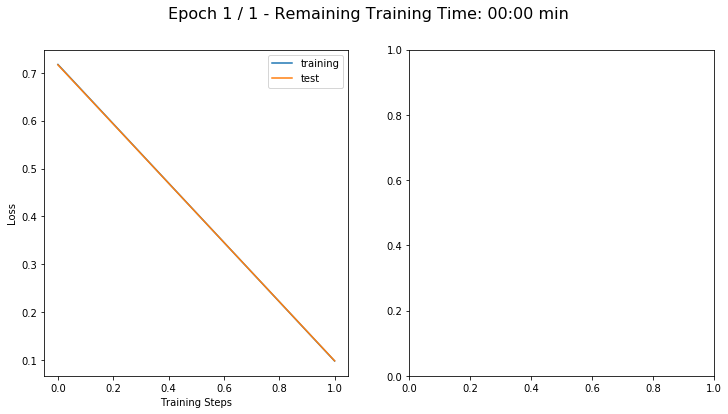

Training ended at 18:09:43. Duration was 15.42 minutes.


In [66]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 1
learning_rate = tf.optimizers.schedules.ExponentialDecay(0.001, 5000, 0.97, staircase=True) #polynomial?
running_average_factor = 0.95

# Initialize the model.
model = VAE()


# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
# loss_func = tf.keras.losses.BinaryCrossentropy()
# loss_func = lambda x, rv_x: -rv_x.log_prob(x)
loss_func = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

#
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(f"Training started at {current_time}.")

#testing once before we begin
test_loss = test_step(model, test_ds, loss_func)
test_losses.append(test_loss)

#check how model performs on train data once before we begin
train_loss = test_step(model, train_ds, loss_func)
train_losses.append(train_loss)
print(model.summary())

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train_ds:
        #train_loss = train_step(model, data, target, loss_func, optimizer)
        train_loss = train_step(model, data, target, loss_func, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss= test_step(model, test_ds, loss_func)
    test_losses.append(test_loss)
    
    end = time.perf_counter()
    print(train_losses)
    plot_performance(num_epochs, train_losses, test_losses, (start, end))

t2 = time.localtime()
current_time2 = time.strftime("%H:%M:%S", t)
t_delta = time.mktime(t2)-time.mktime(t)
print(f"Training ended at {current_time}. Duration was {t_delta/60:.2f} minutes.")

In [67]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())



NameError: name 'eval_dataset' is not defined

In [ ]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())


In [ ]:
images = model(data,training=False).numpy()

x_test = list(map(lambda x: x[0], test_ds))
x_test = tfds.as_numpy(test_ds)
n = 15
plt.figure(figsize=(20, 4))
for i in range(n):
  #display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(np.squeeze(data[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  #ax = plt.subplot(2, n, i + 1)
  # print(images[i].shape)
  plt.imshow(np.squeeze(images[i]))
  plt.title("construct")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()